In [1]:
import tqdm as notebook_tqdm
import pickle


In [2]:
from datasets import load_dataset

dataset = load_dataset("dbpedia_14")

Found cached dataset dbpedia_14 (/home/sriteja/.cache/huggingface/datasets/dbpedia_14/dbpedia_14/2.0.0/01dab9e10d969eadcdbc918be5a09c9190a24caeae33b10eee8f367a1e3f1f0c)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 70000
    })
})


In [4]:
train_dataset = dataset['train']
test_dataset = dataset['test']

# Convert train and test datasets to arrays
train_data_title = train_dataset['title']
train_data_content = train_dataset['content']
train_labels = train_dataset['label']
test_data_title = test_dataset['title']
test_data_content = test_dataset['content']
test_labels = test_dataset['label']



## Preprocess

In [5]:
# load from pkl file
with open('dbpedia_train_tokens.pkl', 'rb') as file:
    tokens = pickle.load(file)
    
with open('dbpedia_test_tokens.pkl', 'rb') as file:
    tokens_test = pickle.load(file)

In [6]:
# in train data replace every 1000th word with UNK randomly

import random

for i in range(len(tokens)):
    for j in range(len(tokens[i])):
        if random.randint(1, 1000) == 1:
            tokens[i][j] = 'UNK'
        

In [7]:
# find length of longest sentence
max_len = 0
for i in range(len(tokens)):
    if len(tokens[i]) > max_len:
        max_len = len(tokens[i])
        
# find length of shortest sentence
min_len = 1000000
for i in range(len(tokens)):
    if len(tokens[i]) < min_len:
        min_len = len(tokens[i])
        
print("Max length: ", max_len)
print("Min length: ", min_len)

# number of sentences with length > 100
count = 0
for i in range(len(tokens)):
    if len(tokens[i]) > 100:
        count += 1
        
print("Number of sentences with length > 100: ", count)

# remove sentences with length > 100 along with their labels
new_tokens = []
new_labels = []
for i in range(len(tokens)):
    if len(tokens[i]) <= 100:
        new_tokens.append(tokens[i])
        new_labels.append(train_labels[i])
        
# remove so in test also
new_tokens_test = []
new_labels_test = []
for i in range(len(tokens_test)):
    if len(tokens_test[i]) <= 100:
        new_tokens_test.append(tokens_test[i])
        new_labels_test.append(test_labels[i])
        
print(len(new_tokens))
print(len(new_labels))
print(len(new_tokens_test))
print(len(new_labels_test))

Max length:  1473
Min length:  3
Number of sentences with length > 100:  1207
558793
558793
69839
69839


In [8]:
# for tetst data
# find length of longest sentence
max_len_test = 0
for i in range(len(tokens_test)):
    if len(tokens_test[i]) > max_len_test:
        max_len_test = len(tokens_test[i])
        
# find length of shortest sentence
min_len_test = 1000000
for i in range(len(tokens_test)):
    if len(tokens_test[i]) < min_len_test:
        min_len_test = len(tokens_test[i])
        
print("Max length: ", max_len_test)
print("Min length: ", min_len_test)

Max length:  507
Min length:  4


In [9]:
# add padding to all sentences and S and EOS tokens
def padding(tokens, max_len):
    for i in range(len(tokens)):
        tokens[i] = ['S'] + tokens[i] + ['EOS']
        while len(tokens[i]) < max_len:
            tokens[i].append('PAD')
    return tokens

In [10]:
max_len = 102
tokens = padding(new_tokens, max_len)
tokens_test = padding(new_tokens_test, max_len)

In [11]:

# Create a vocabulary by collecting unique words from the training data
vocab = set()
for token in tokens:
    vocab.update(token)

# Create a dictionary to map words to indices in the vocabulary
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

print(word_to_idx['the'])
print(idx_to_word[0])
print(word_to_idx['NUM'])
print(word_to_idx['UNK'])
print(word_to_idx['PAD'])
print(word_to_idx['S'])
print(word_to_idx['EOS'])
print(word_to_idx['MID'])

523562
lenticular
694806
36282
442904
454389
341337
439052


In [12]:
batch_size = 32
num_classes = 14
vocab_size = len(vocab)
num_epochs = 3
learning_rate = 0.00001
embedding_size = 300
hidden_size = 128

## Pytorch

## Keras

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTMCell, RNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert tokens and labels to Keras format
# Note: Ensure tokens and new_labels are numpy arrays
X_train = [[word_to_idx.get(token, word_to_idx['UNK']) for token in sentence] for sentence in tokens]
X_test = [[word_to_idx.get(token, word_to_idx['UNK']) for token in sentence] for sentence in tokens_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

# Convert labels to one-hot format
y_train = to_categorical(new_labels, num_classes=num_classes)
y_test = to_categorical(new_labels_test, num_classes=num_classes)

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-12-01 04:48:53.503300: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 04:48:53.529506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 04:48:53.648352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 04:48:53.649080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 04:48:54.452064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [22]:
# # Model
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, mask_zero=True))
# model.add(RNN(LSTMCell(hidden_size)))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(optimizer=Adam(learning_rate=learning_rate),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [23]:
# from tensorflow.keras.utils import Progbar

# # Train model
# for epoch in range(num_epochs):
#     print(f'Epoch {epoch + 1}/{num_epochs}')
    
#     # Initialize Progbar with the total number of batches
#     progbar = Progbar(len(X_train) // batch_size)
    
#     # Training
#     for i in range(0, len(X_train), batch_size):
#         X_batch = X_train[i:i + batch_size]
#         y_batch = y_train[i:i + batch_size]
        
#         # Check batch size; skip if it's not 32
#         if len(X_batch) != 32:
#             continue
        
#         batch_loss, batch_acc = model.train_on_batch(X_batch, y_batch)
        
#         # Update progbar with the batch's metrics
#         progbar.add(1, values=[('loss', batch_loss), ('accuracy', batch_acc)])
    
#     # Save the model after each epoch
#     model.save(f"dbpedia_keras_model_epoch_{epoch+1}.h5")


Epoch 1/3


2023-10-31 12:36:35.657519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,14]
	 [[{{node Placeholder/_1}}]]


    1/17462 [..............................] - ETA: 20:50:08 - loss: 2.6268 - accuracy: 0.0000e+00

2023-10-31 12:36:40.061046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,14]
	 [[{{node Placeholder/_1}}]]


    2/17462 [..............................] - ETA: 18:20:26 - loss: 2.6260 - accuracy: 0.0000e+00

2023-10-31 12:36:43.994149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,14]
	 [[{{node Placeholder/_1}}]]


In [14]:
# load model lstm_dbpedia.keras
from tensorflow.keras.models import load_model
model = load_model('lstm_dbpedia.keras')

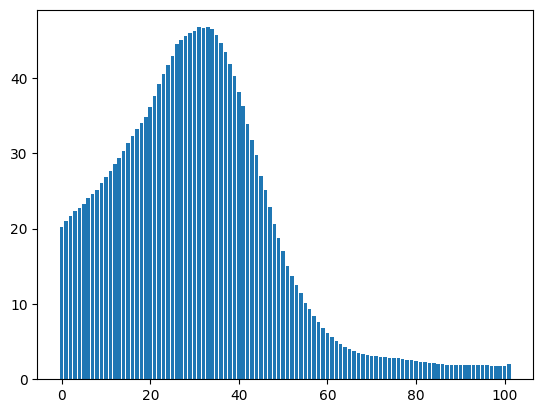

In [18]:
import matplotlib.pyplot as plt

# Create a new model that outputs both the predictions and the embeddings
# Assume 'embedding' is the name of your embedding layer
embedding_output = model.get_layer('embedding').output
grad_model = tf.keras.models.Model(inputs=model.input, outputs=[model.output, embedding_output])

# Select a sample
sample = X_test[0:1]

# Compute the gradients
with tf.GradientTape() as tape:
    # Run this sample through the grad_model
    predictions, embeddings = grad_model(sample)
    # Choose the class with the highest probability
    class_idx = np.argmax(predictions[0])
    # Compute the loss
    loss = predictions[:, class_idx]

    # Ensure the embeddings are being watched
    tape.watch(embeddings)

# Get the gradients of the loss with respect to the embedding output
gradients = tape.gradient(loss, embeddings)

# Check if gradients are None
if gradients is not None:
    # Sum the gradients across the input sequence
    summed_gradients = tf.reduce_sum(tf.abs(gradients), axis=-1).numpy()[0]

    # Plot
    plt.bar(range(len(summed_gradients)), summed_gradients)
    plt.show()
else:
    print("Gradients could not be computed.")
